<a href="https://colab.research.google.com/github/Marcelo-Rocha-UFF/Processamento-de-Imagens-e-Sinais-Biol-gicos/blob/main/P_I_S_B_Final_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

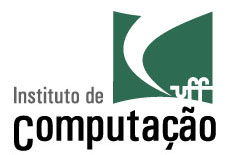



---


# **Biological Image and Signal Processing**
### **Towards Voice Emotion Recognition Using Histogram Feature Through a Graphical Approach**

**Professor**: Aura Conci

**Student**: Marcelo Marques da Rocha

## **Week 01 - Design a Possible Solution** (April 27th)
What are the next steps related to do?

* Features Computation (**why** the features are **chosen**?)
* **Steps** that will be follow in the **processing phase**...
* **What** is considered a **solution** for the initial problem?
* What is the **input**?
* How is the **output**?
* **How** will be the **evaluation** of the solution?
* **What** will be the **computational tools** to be used ?


## **Week 02 - Solving the Problem** (May 04th)


### **Importando as bibliotecas**

In [ ]:
# Import libraries 
import cv2
from google.colab.patches import cv2_imshow
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import specgram
import pandas as pd
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings

import sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### **Acessando o Dataset no Drive**



In [ ]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

### **Using a reduced version of TESS (*Toronto Emotional Speech Set*) Dataset**

Foram mantidas no dataset as emoções:
- **Angry** (200 frases)
- **Happy** (200 frases)
- **Neutral** (200 frases)
- **Sad** (200 frases)

São quatro pastas com 200 amostras de cada emoção com a voz de uma mesma atriz, ou seja, são vozes femininas.

### **Configuração dos paths das pastas das amostras**

In [ ]:
# Using the TESS dataset (reduced)
path_SPECS = '/content/drive/MyDrive/TESS/SPECS_0_to_192Hz/'
dir_SPECS = os.listdir(path_SPECS) 
dir_SPECS.sort()

path_TESS = '/content/drive/MyDrive/TESS/'
path_angry = path_TESS + 'angry/'
dir_angry = os.listdir(path_angry) 
dir_angry.sort()

path_happy = path_TESS + 'happy/'
dir_happy = os.listdir(path_happy)
dir_happy.sort()

path_neutral = path_TESS + 'neutral/'
dir_neutral = os.listdir(path_neutral)
dir_neutral.sort()

path_sad = path_TESS + 'sad/'
dir_sad = os.listdir(path_sad)
dir_sad.sort()

print("Emotion (Type)\tTotal")
print("=====================")
print("Angry\t\t", len(dir_angry))
print("Happy\t\t", len(dir_happy))
print("Neutral\t\t", len(dir_neutral))
print("Sad\t\t", len(dir_sad))

Emotion (Type)	Total
Angry		 200
Happy		 200
Neutral		 200
Sad		 200


In [ ]:
# definindo contantes
SAMPLE_RATE = 44100

### **Funções de Processamento**

#### **Função que plota a amostra no domínio do Tempo**



In [ ]:
def plota(emotion, word):
  fname = path_TESS + emotion + '/' + 'YAF_' + word + '_' + emotion + '.wav'
  data, sampling_rate = librosa.load(fname, sr=SAMPLE_RATE)
  plt.figure(figsize=(15, 5))
  plt.title(fname)
  librosa.display.waveplot(data, sr=sampling_rate)
  return fname

 

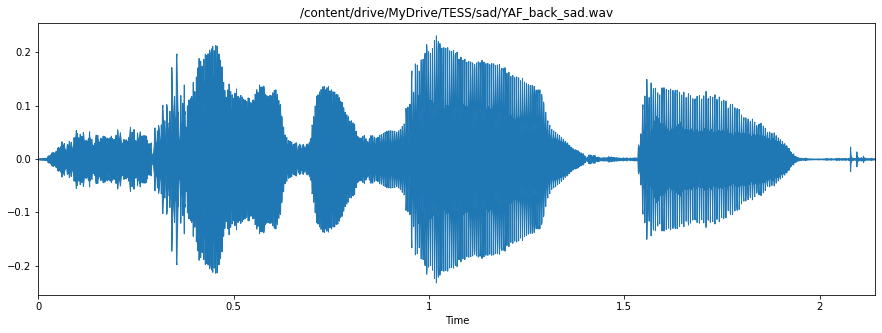

In [ ]:
# exemplo
file = plota("sad", "back")

In [ ]:
print(file)
ipd.Audio(file)

/content/drive/MyDrive/TESS/sad/YAF_back_sad.wav


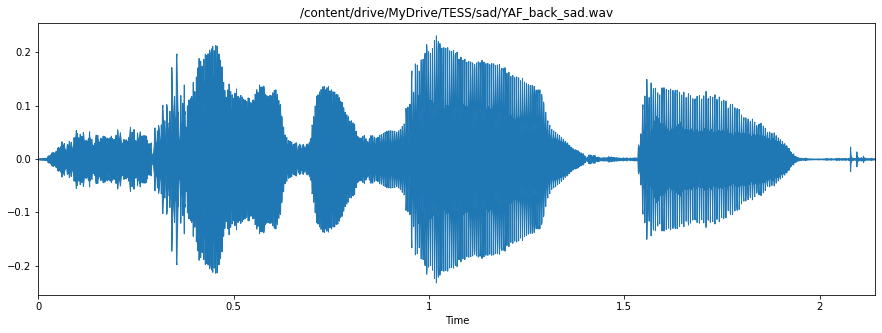

In [ ]:
# exemplo
file = plota("sad", "back")

In [ ]:
print(file)
ipd.Audio(file)

/content/drive/MyDrive/TESS/sad/YAF_back_sad.wav


#### **Função que plota o Spectrograma MFCC da amostra**

In [ ]:
def plota_mfcc(emotion, word):
  fname = path_TESS + emotion + '/' + 'YAF_' + word + '_' + emotion + '.wav'
  y, sr = librosa.load(fname, sr=SAMPLE_RATE, duration = 5) # Chop audio at 5 secs... 
  mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc = 5) # 20 MFCC components

  plt.figure(figsize=(15, 15))
  plt.subplot(3,1,1)
  librosa.display.specshow(mfcc)
  plt.ylabel('MFCC')
  plt.title(fname)
  plt.colorbar()
  return fname

#### **Função que plota duas séries temporais no mesmo gráfico**

In [ ]:
def plota_duas_series(val1, lab1, val2, lab2):
  plt.figure(figsize=(20, 15))
  plt.subplot(3,1,1)
  plt.plot(val1, label=lab1)
  plt.plot(val2, label=lab2)
  plt.legend()

#### **Função que plota a amostra no domínio da frequência usando a STFT (Short-Time Fourrier Transform)**

In [ ]:
def plota_stft(emotion, word, y_type='linear', title=True, file_name=None):
  if file_name == None:
    fname = path_TESS + emotion + '/' + 'YAF_' + word + '_' + emotion + '.wav'
  else:
    fname = path_TESS + emotion + '/' + file_name
    pos = []
    for l in range(len(fname)):
      if fname[l] == "_":
        pos.append(l)
    word = fname[pos[0]+1 : pos[1]]
    print("Word:", word)

  y, sr = librosa.load(fname, sr=SAMPLE_RATE, duration = 5) # Chop audio at 5 secs...
  S = np.abs(librosa.stft(y))
  fig, ax = plt.subplots()
  img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis=y_type, x_axis='time', ax=ax)
  if title:
    ax.set_title('Power spectrogram: ' + fname)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
  plt.savefig('SPEC_' + word + '_' + emotion + '.png', format='png')
  return 'SPEC_' + word + '_' + emotion + '.png'


'SPEC_hate_neutral.png'

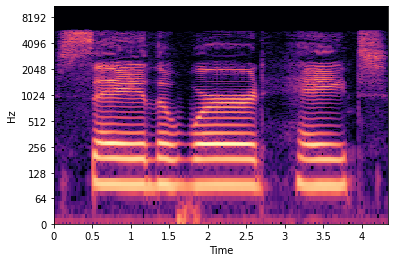

In [ ]:
plota_stft("neutral", "hate", "log", False)

#### **Função que seleciona a ROI da Imagem e a salva no drive**

In [ ]:
def selec_roi(path_grafico_completo):
  # fname = path_TESS + emotion + '/' + 'YAF_' + word + '_' + emotion + '.wav'
  # y, sr = librosa.load(fname, sr=SAMPLE_RATE, duration = 5) # Chop audio at 5 secs...
  # S = np.abs(librosa.stft(y))

  fig, ax = plt.subplots()
  # img_stft = cv2.imread("teste.png")
  # color = ('b', 'g', 'r')
  # for i, col in enumerate(color):
  #   hist = cv2.calcHist([img_stft], [i], None, [256], [0, 256])
    #plt.plot(hist, color = col)
    #plt.xlim([0, 256])
    #cv2_imshow(img_stft)
  img_array=plt.imread(path_grafico_completo)[185:252,55:390]
  plt.axis('off')
  plt.imshow(img_array)
  plt.savefig(path_grafico_completo, format='png')
  print(path_grafico_completo)

  

#### **Função que calcula a média das distâncias....**

In [ ]:
# Source - TESS; Gender - Female;
def compara_emocoes(emotion1, emotion2):
  fname1 = path_TESS + emotion1 + '/' + 'YAF_back_' + emotion1 + '.wav'
  X, sample_rate = librosa.load(fname1, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)  
  emotion1_mfcc = librosa.feature.mfcc(y=X, sr=SAMPLE_RATE, n_mfcc=13)
  emotion1_mean = np.mean(emotion1_mfcc, axis=0)
  #print(len(emotion1_mean), emotion1_mean.shape)

  # Source - TESS; Gender - Female;  
  fname2 = path_TESS + emotion2 + '/' + 'YAF_back_' + emotion2 + '.wav'
  X, sample_rate = librosa.load(fname2, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)  
  emotion2_mfcc = librosa.feature.mfcc(y=X, sr=SAMPLE_RATE, n_mfcc=13)
  emotion2_mean = np.mean(emotion2_mfcc, axis=0)

  #print(len(emotion2_mean), emotion2_mean.shape)

  print("Comparando: ", fname1, " e", fname2 )

  #for i in range(len(emotion2_mean)-5): # Deslocamento para ajustar as series temporais
  # emotion2_mean[i] = emotion2_mean[i+5]

  dist_sum = 0

  interval = min(len(emotion1_mean), len(emotion2_mean))

  distancias = []

  for i in range(interval):
    distancias.append((abs(emotion1_mean[i] - emotion2_mean[i])))

  dist_media = np.mean(distancias)
  dist_dp = np.std(distancias)
  dist_mediana = np.median(distancias)
  dist_var = np.var(distancias)
  print("Dist média:", dist_media, "Desvio padrão:", dist_dp, "Mediana:", dist_mediana, "Variancia", dist_var)

  return emotion1_mean, emotion1, emotion2_mean, emotion2, fname1, fname2

In [ ]:
em1_mean, em1, em2_mean, em2, fname1, fname2 = compara_emocoes("sad", "neutral")

Comparando:  /content/drive/MyDrive/TESS/sad/YAF_back_sad.wav  e /content/drive/MyDrive/TESS/neutral/YAF_back_neutral.wav
Dist média: 7.5494146 Desvio padrão: 4.983345 Mediana: 6.155802 Variancia 24.833729


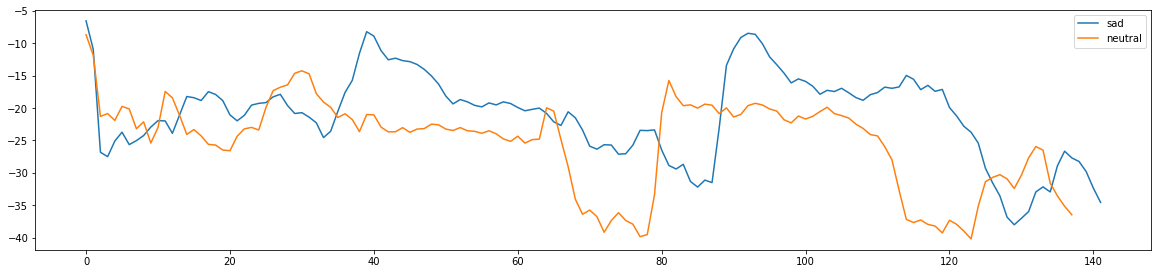

In [ ]:
plota_duas_series(em1_mean, em1, em2_mean, em2)

#### **Função que mostra histograma dos canais (RGB) selecionados da imagem**

In [ ]:
def mostra_hist(img, canal):
  img_spec = cv2.imread('/content/drive/MyDrive/TESS/SPECS_0_to_192Hz/' + img)

  pixels_canal_b = [] # pixels do canal blue:0
  pixels_canal_g = [] # pixels do canal green:1
  pixels_canal_r = [] # pixels do canal red:2

  for x in range(54, 389 ): # seleciona a regiao de interesse da imagem
    for y in range(110, 177):
      pixels_canal_b.append(img_spec[y, x, 0]) # extrai os pixels do canal blue e coloca na lista

  for x in range(54, 389 ): # seleciona a regiao de interesse da imagem
    for y in range(110, 177):
      pixels_canal_g.append(img_spec[y, x, 1]) # extrai os pixels do canal green e coloca na lista

  for x in range(54, 389 ): # seleciona a regiao de interesse da imagem
    for y in range(110, 177):
      pixels_canal_r.append(img_spec[y, x, 2]) # extrai os pixels do canal red e coloca na lista

  #plt.ylim(0, 1000)
  if 'b' in canal.lower(): sns.histplot(np.array(pixels_canal_b), bins=256, color="blue", binwidth=1)
  if 'g' in canal.lower(): sns.histplot(np.array(pixels_canal_g), bins=256, color="green", binwidth=1)
  if 'r' in canal.lower(): sns.histplot(np.array(pixels_canal_r), bins=256, color="red", binwidth=1)


### **Demonstrando os uso de algumas funções de processamento**

#### **Gerando os Spectrogramas (STFT) das quatro emoções com a palavra "hate"**

'SPEC_hate_neutral.png'

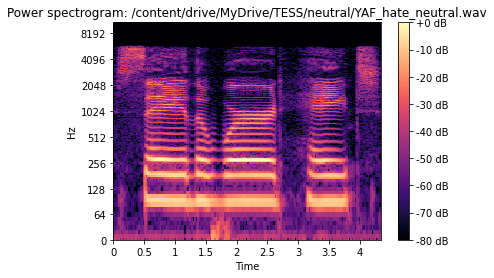

In [ ]:
plota_stft("neutral", "hate", "log")

'SPEC_hate_sad.png'

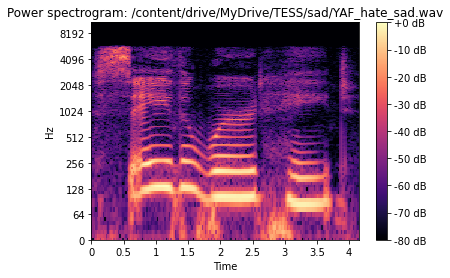

In [ ]:
plota_stft("sad", "hate",  "log")

'SPEC_hate_happy.png'

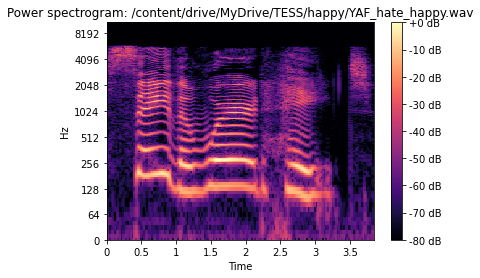

In [ ]:
plota_stft("happy", "hate", "log")

'SPEC_hate_angry.png'

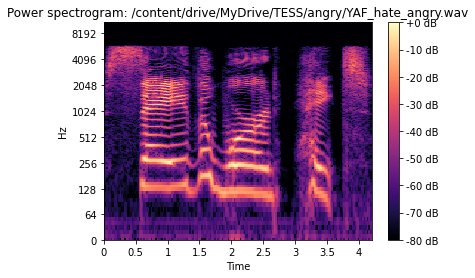

In [ ]:
plota_stft("angry", "hate", "log")

#### **Gerando os Spectrogramas (MFCC) das quatro emoções com a palavra "hate"**

'/content/drive/MyDrive/TESS/neutral/YAF_hate_neutral.wav'

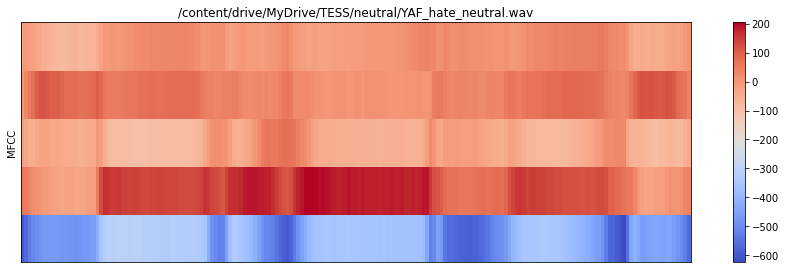

In [ ]:
plota_mfcc("neutral", "hate")

'/content/drive/MyDrive/TESS/sad/YAF_hate_sad.wav'

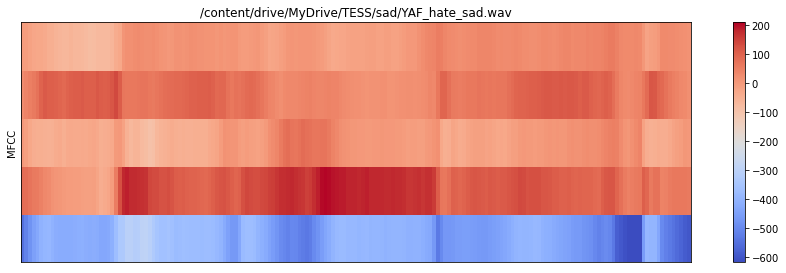

In [ ]:
plota_mfcc("sad", "hate")

'/content/drive/MyDrive/TESS/happy/YAF_hate_happy.wav'

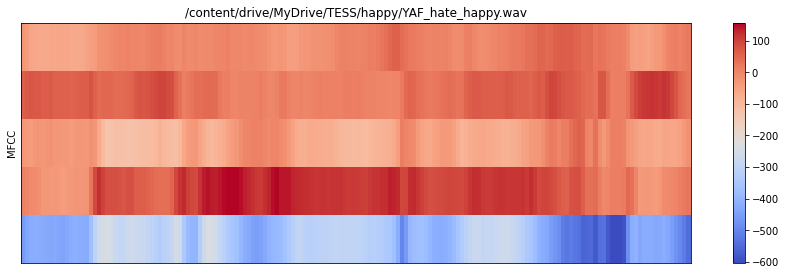

In [ ]:
plota_mfcc("happy", "hate")

'/content/drive/MyDrive/TESS/angry/YAF_hate_angry.wav'

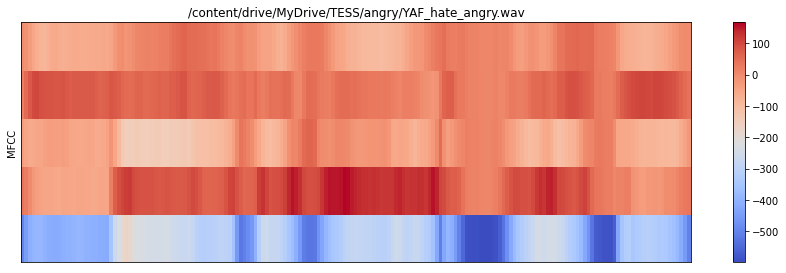

In [ ]:
plota_mfcc("angry", "hate")

### **Histograma dos canais RGB das imagens dos spectrogramas das emoções: *Angry*, *Happy*, *Neutral* e *Sad***

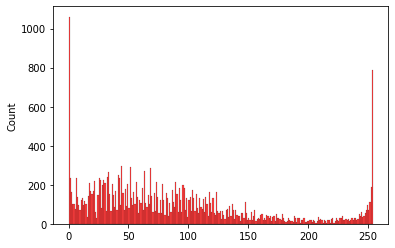

In [ ]:
mostra_hist(dir_SPECS[1], 'r')

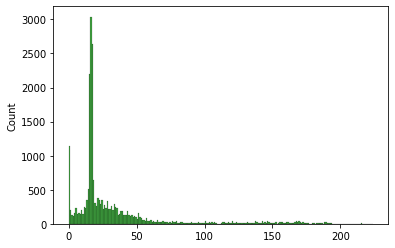

In [ ]:
mostra_hist(dir_SPECS[1], 'g')

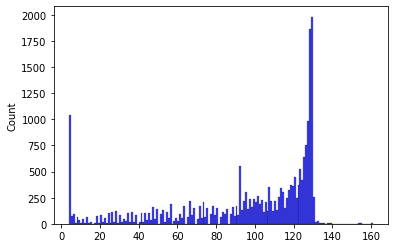

In [ ]:
mostra_hist(dir_SPECS[1], 'b')

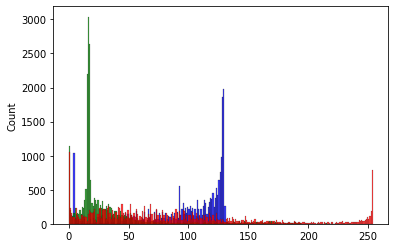

In [ ]:
mostra_hist(dir_SPECS[1], 'rgb')

### **(NÃO RODAR) Etapas 1 e 2 - Gerando os Spectrogramas e selecionando a região de interesse que é de 0Hz à 192Hz**

#### **Gerando os Spectrogramas da emoção SAD já com a região de interesse selecionada**

Word: back
SPEC_back_sad.png
YAF_back_sad.wav
Word: bar
SPEC_bar_sad.png
YAF_bar_sad.wav
Word: base
SPEC_base_sad.png
YAF_base_sad.wav
Word: bath
SPEC_bath_sad.png
YAF_bath_sad.wav
Word: bean
SPEC_bean_sad.png
YAF_bean_sad.wav
Word: beg
SPEC_beg_sad.png
YAF_beg_sad.wav
Word: bite


KeyboardInterrupt: ignored

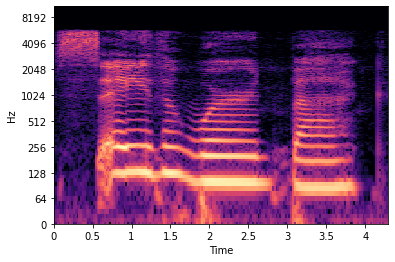

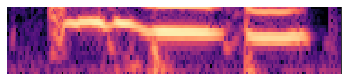

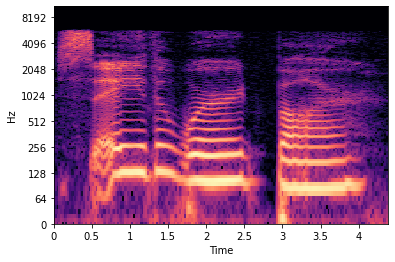

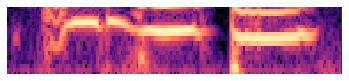

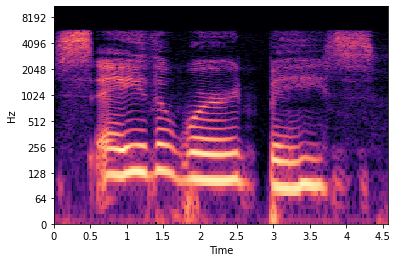

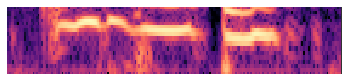

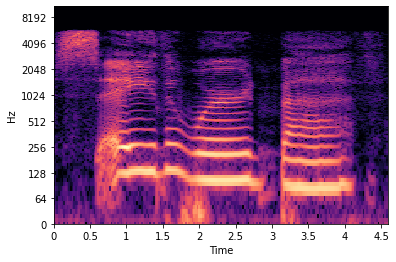

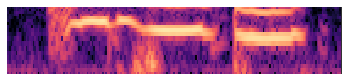

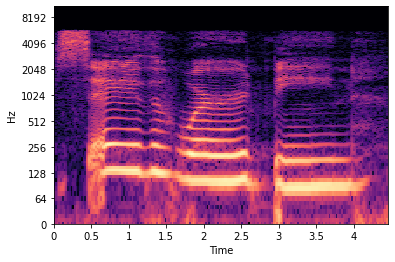

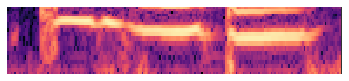

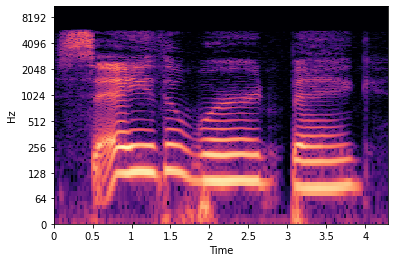

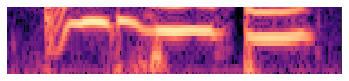

In [ ]:
#
for i in range(len(dir_sad)):
  selec_roi(plota_stft("sad", "", "log", False, dir_sad[i]))
  print(dir_sad[i])

#copiando arquivos para o drive
!cp /content/*.* /content/drive/MyDrive/TESS/SPECS_0_to_192Hz/
#removendo arquivos
!rm *.*

#### **Gerando os Spectrogramas da emoção ANGRY já com a região de interesse selecionada**


In [ ]:
#
for i in range(len(dir_angry)):
  selec_roi(plota_stft("angry", "", "log", False, dir_angry[i]))
  print(dir_angry[i])

#copiando arquivos para o drive
!cp /content/*.* /content/drive/MyDrive/TESS/SPECS_0_to_192Hz/
#removendo arquivos
!rm *.*


#### **Gerando os Spectrogramas da emoção NEUTRAL já com a região de interesse selecionada**


In [ ]:
#
for i in range(len(dir_neutral)):
  selec_roi(plota_stft("neutral", "", "log", False, dir_neutral[i]))
  print(dir_neutral[i])

#copiando arquivos para o drive
!cp /content/*.* /content/drive/MyDrive/TESS/SPECS_0_to_192Hz/
#removendo arquivos
!rm *.*

#### **Gerando os Spectrogramas da emoção HAPPY já com a região de interesse selecionada**

In [ ]:
#
for i in range(len(dir_happy)):
  selec_roi(plota_stft("happy", "", "log", False, dir_happy[i]))
  print(dir_happy[i])

#copiando arquivos para o drive
!cp /content/*.* /content/drive/MyDrive/TESS/SPECS_0_to_192Hz/
#removendo arquivos
!rm *.*

In [ ]:
#img_spec = cv2.imread('/content/drive/MyDrive/TESS/SPECS_0_to_192Hz/SPEC_back_happy.png')
def calc_media(img):
  img_spec = cv2.imread('/content/drive/MyDrive/TESS/SPECS_0_to_192Hz/' + img)
  canais = [1,2]
  for c in canais: # zera os canais 1 (verde) e 2 (vermelho)
    for x in range(54, 389 ): # 54 a 388
      for y in range(110, 177):
        img_spec[y, x, c] = 0

  for x in range(54, 389 ): # zerando os valores do azul abaixo de 150
      for y in range(110, 177):
        if img_spec[y, x, 0] < 150:
          img_spec[y, x, 0] = 0

  blue_selected = np.zeros(shape=(335 * 67))

  indice = 0
  for x in range(54, 389 ): # zerando os valores do azul abaixo de 150
      for y in range(110, 177):
        blue_selected[indice] = img_spec[y, x, 0]
        #print(blue_selected[indice])
        indice = indice + 1
        

  #print('Imagem:', img, ', Média:', blue_selected.mean(), ", Desvio:", blue_selected.std())

  return blue_selected.mean()
  #cv2_imshow(img_spec)


In [ ]:
calc_media(dir_SPECS[qtd * 4 + emotion])

6.150590331922477

In [ ]:
data = []
# Criando um dataframe do pandas
#df = pd.DataFrame(data, columns=['Nome', 'Idade'])
for qtd in range(1): # numero de testes

  for emotion in range(4):
    linha = []
    blue_mean = calc_media(dir_SPECS[qtd * 4 + emotion])
    pos = []
    for l in range(len(dir_SPECS[qtd * 4 + emotion])):
      if (dir_SPECS[qtd * 4 + emotion][l] == "_" or dir_SPECS[qtd * 4 + emotion][l] == '.'):
        pos.append(l)

    word = dir_SPECS[qtd * 4 + emotion][pos[0]+1 : pos[1]]
    emotion_string = dir_SPECS[qtd * 4 + emotion][pos[1]+1 : pos[2]]

    linha.append(dir_SPECS) # nome do arquivo
    linha.append(emotion_string) # rótulo da emoção
    linha.append(word) # palavra
    linha.append('xxx') # media dos 3 canais de cor
    linha.append(blue_mean) # media da região selecionada do canal azul
    data.append(linha)
data
#df = pd.DataFrame(data, columns=['Sample', 'Emotion', 'Word', 'RGB (Mean)', 'Blue Selected (Mean)'])

linha [['SPEC_back_angry.png', 'SPEC_back_happy.png', 'SPEC_back_neutral.png', 'SPEC_back_sad.png', 'SPEC_bar_angry.png', 'SPEC_bar_happy.png', 'SPEC_bar_neutral.png', 'SPEC_bar_sad.png', 'SPEC_base_angry.png', 'SPEC_base_happy.png', 'SPEC_base_neutral.png', 'SPEC_base_sad.png', 'SPEC_bath_angry.png', 'SPEC_bath_happy.png', 'SPEC_bath_neutral.png', 'SPEC_bath_sad.png', 'SPEC_bean_angry.png', 'SPEC_bean_happy.png', 'SPEC_bean_neutral.png', 'SPEC_bean_sad.png', 'SPEC_beg_angry.png', 'SPEC_beg_happy.png', 'SPEC_beg_neutral.png', 'SPEC_beg_sad.png', 'SPEC_bite_angry.png', 'SPEC_bite_happy.png', 'SPEC_bite_neutral.png', 'SPEC_bite_sad.png', 'SPEC_boat_angry.png', 'SPEC_boat_happy.png', 'SPEC_boat_neutral.png', 'SPEC_boat_sad.png', 'SPEC_bone_angry.png', 'SPEC_bone_happy.png', 'SPEC_bone_neutral.png', 'SPEC_bone_sad.png', 'SPEC_book_angry.png', 'SPEC_book_happy.png', 'SPEC_book_neutral.png', 'SPEC_book_sad.png', 'SPEC_bought_angry.png', 'SPEC_bought_happy.png', 'SPEC_bought_neutral.png', 'SP

### **Etapa 3 - Calculando a média do canal de cor passada como parâmetro e criando o dataframe**

#### **Função que calcula a média do canal de cor (selecionado) no histograma  no intervalo de 0Hz a 192Hz usando o limiar especificado como parâmetro. Sentido crescente "up"**
Essa função recebe o nome do arquivo da imagem a ser analisada e um limiar (sentido crescente) que é usado na filtragem do canal. O valor default de "limiar" é 150.

In [ ]:
def calc_media_up(img, limiar=150, canal_de_cor='green', opcao=1):
  img_spec = cv2.imread('/content/drive/MyDrive/TESS/SPECS_0_to_192Hz/' + img)

  pixels_canal = [] # pixels do canal especificado, extraidos da imagem BGR
  cor = {"blue":0, "green":1, "red":2}
  canal = cor[canal_de_cor] # 0 : blue, 1 : green, 2 : red
  for x in range(54, 389 ): # seleciona a regiao de interesse da imagem
    for y in range(110, 177):
      pixels_canal.append(img_spec[y, x, canal]) # extrai os pixels do canal selecionado e coloca na lista
      
  unique, counts = np.unique(np.array(pixels_canal), return_counts=True)
  
  #print("len unique:", len(unique), unique, "\nlen de counts:", len(counts), counts)

  pixels_sel_freq = [] # lista com as frequencias dos pixels selecionados a partir do limiar

  ind_unique = 0
  for i in range(256): # montando a lista com as freq do canal, incluindo as com freq = 0
    if ind_unique < len(unique):
      if i == unique[ind_unique]:
        pixels_sel_freq.append(counts[ind_unique]/256)
        ind_unique += 1
      else:
        pixels_sel_freq.append(0)
    else:
      pixels_sel_freq.append(0)

  #print("len de freq", len(pixels_sel_freq))
  #print("freq", pixels_sel_freq)

  #limiar = pixels_sel_freq.index(max(pixels_sel_freq)) # automatico

  if len(pixels_sel_freq[limiar:]) > 0:
    media1 = np.array(pixels_sel_freq[limiar:]).mean()
    media2: sum(pixels_sel_freq[limiar:]) / (256 - limiar)
  else:
    media1 = 0
    media2 = 0

  #lnz (the number of color levels with non-zero frequency)
  if opcao == 1:
    lnz = len(pixels_sel_freq[limiar:]) # inclui os elementos com zero de freq.
  else:
    lnz = len(list(filter(lambda num: num != 0, pixels_sel_freq[limiar:] ))) # exlui os zeros, podendo tornar a qtd menor
    
  #print(len(pixels_sel_freq[limiar:]), pixels_sel_freq[limiar:])
  #print(len(list(filter(lambda num: num != 0, pixels_sel_freq[limiar:] ))), list(filter(lambda num: num != 0, pixels_sel_freq[limiar:])))
  return media1, lnz #lnz (the number of color levels with non-zero frequency)
  #### #cv2_imshow(img_spec)


In [ ]:
calc_media_up(dir_SPECS[3], 150, "blue", 1)

(0.030918337264150945, 106)

#### **Função que calcula a média do canal de cor (selecionado) no histograma  no intervalo de 0Hz a 192Hz usando o (<= limiar) especificado como parâmetro. Sentido decrescente "down"****
Essa função recebe o nome do arquivo da imagem a ser analisada e um limiar (sentido decrescente) que é usado na filtragem do canal. O valor default de "limiar" é 150.

In [ ]:
def calc_media_down(img, limiar=150, canal_de_cor='green', opcao=1):
  img_spec = cv2.imread('/content/drive/MyDrive/TESS/SPECS_0_to_192Hz/' + img)

  pixels_canal = [] # pixels do canal especificado, extraidos da imagem BGR
  cor = {"blue":0, "green":1, "red":2}
  canal = cor[canal_de_cor] # 0 : blue, 1 : green, 2 : red
  for x in range(54, 389 ): # seleciona a regiao de interesse da imagem
    for y in range(110, 177):
      pixels_canal.append(img_spec[y, x, canal]) # extrai os pixels do canal selecionado e coloca na lista
      
  unique, counts = np.unique(np.array(pixels_canal), return_counts=True)
  
  #print("len unique:", len(unique), unique, "\nlen de counts:", len(counts), counts)

  pixels_sel_freq = [] # lista com as frequencias dos pixels selecionados a partir do limiar

  ind_unique = 0
  for i in range(256): # montando a lista com as freq do canal, incluindo as com freq = 0
    if ind_unique < len(unique):
      if i == unique[ind_unique]:
        pixels_sel_freq.append(counts[ind_unique]/256)
        ind_unique += 1
      else:
        pixels_sel_freq.append(0)
    else:
      pixels_sel_freq.append(0)

  #print("len de freq", len(pixels_sel_freq))
  #print("freq", pixels_sel_freq)
  if len(pixels_sel_freq[:(limiar+1)]) > 0:
    media1 = np.array(pixels_sel_freq[:limiar+1]).mean()
    media2: sum(pixels_sel_freq[:limiar+1]) / (256 - limiar)
  else:
    media1 = 0
    media2 = 0

  #lnz (the number of color levels with non-zero frequency)
  if opcao == 1:
    lnz = len(pixels_sel_freq[:limiar+1]) # inclui os elementos com zero de freq.
  else:
    lnz = len(list(filter(lambda num: num != 0, pixels_sel_freq[:limiar+1] ))) # exlui os zeros, podendo tornar a qtd menor
  
  #sns.histplot(np.array(pixels_canal_b), bins=256, color="blue", binwidth=3)

  #print(len(pixels_sel_freq[limiar:]), pixels_sel_freq[limiar:])
  #print(len(list(filter(lambda num: num != 0, pixels_sel_freq[limiar:] ))), list(filter(lambda num: num != 0, pixels_sel_freq[limiar:])))
  
  return media1, lnz #lnz (the number of color levels with non-zero frequency)
  #### #cv2_imshow(img_spec)


#### **Função que executa a análise das imagens e retorna dataframe com os dados**
Essa função recebe como parâmetros a quantidade de frases que serão analisadas e um "limiar". O "limiar" é usado na filtragem do azul. O valor default de "limiar" é 150.

In [ ]:
def analisa_imagens(qtd=200, limiar=150, canal_de_cor='green', opcao=1, way="up"):
  data = []
  print("Processando", qtd, "spectrogramas de cada emoção, usando o limiar de", limiar, ", no canal de cor", canal_de_cor, ", com a opção", opcao, " no sentido:", way )
  for a in range(qtd): # Número de amostras (de 1 à 200)

    for emotion in range(4):
      linha = []
      if way == 'up':
        color_mean, nap = calc_media_up(dir_SPECS[a * 4 + emotion], limiar, canal_de_cor, opcao)
      elif way == 'down':
        color_mean, nap = calc_media_down(dir_SPECS[a * 4 + emotion], limiar, canal_de_cor, opcao)
      pos = []
      for l in range(len(dir_SPECS[a * 4 + emotion])):
        if (dir_SPECS[a * 4 + emotion][l] == "_" or dir_SPECS[a * 4 + emotion][l] == '.'):
          pos.append(l)

      word = dir_SPECS[a * 4 + emotion][pos[0]+1 : pos[1]]
      emotion_string = dir_SPECS[a * 4 + emotion][pos[1]+1 : pos[2]]

      #print(dir_SPECS[nap * 4 + emotion])
      linha.append(dir_SPECS[a * 4 + emotion]) # nome do arquivo
      linha.append(emotion_string) # rótulo da emoção
      linha.append(word) # palavra
      #linha.append('xxx') # media dos 3 canais de cor
      linha.append(color_mean) # media da região selecionada do canal azul
      linha.append(nap)
      data.append(linha)
      #NAP (Number of Active Pixels)
  return pd.DataFrame(data, columns=['Sample', 'Emotion', 'Word', 'MEAN', 'LNZ'])

### **Testando a implemantação gerando alguns gráficos**

#### **Mostrando e explorando o dataset da análise**


##### **Normalizando as colunas MEAN e LNZ**

###### **Função de normalização**

In [ ]:
def normaliza(data_frame): # usando a técica max
  df_scaled = data_frame.copy() 
  for i in df_scaled.iterrows(): 
      df_scaled["MEAN"] = df_scaled["MEAN"]  / df_scaled["MEAN"].abs().max() 
      df_scaled["LNZ"] = df_scaled["LNZ"]  / df_scaled["LNZ"].abs().max()
  return df_scaled

#### **Plotando alguns Gráficos**

##### **Gráficos das Médias em função das Emoções** (Usando os canais Red, Green e Blue)

###### **Canal Vermelho**

Processando 200 spectrogramas de cada emoção, usando o limiar de 150 , no canal de cor red , com a opção 2  no sentido: up


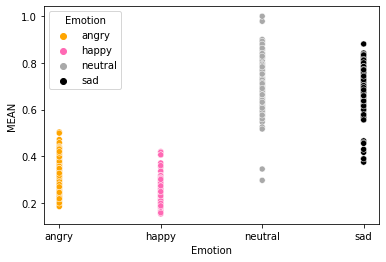

In [ ]:
df = analisa_imagens(200, 150, "red", 2, "up")
df_normalizado = normaliza(df)
sns.scatterplot(data=df_normalizado, x="Emotion", y="MEAN", hue="Emotion", palette=dict(angry="orange", happy="hotpink", neutral="darkgray", sad="black"));

###### **Canal Verde**

Processando 200 spectrogramas de cada emoção, usando o limiar de 150 , no canal de cor green , com a opção 2  no sentido: up


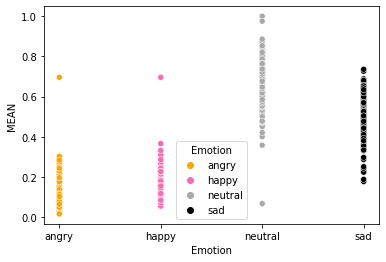

In [ ]:
df = analisa_imagens(200, 150, "green", 2, "up")
df_normalizado = normaliza(df)
sns.scatterplot(data=df_normalizado, x="Emotion", y="MEAN", hue="Emotion", palette=dict(angry="orange", happy="hotpink", neutral="darkgray", sad="black"));

###### **Canal Azul**

Processando 200 spectrogramas de cada emoção, usando o limiar de 150 , no canal de cor blue , com a opção 2  no sentido: up


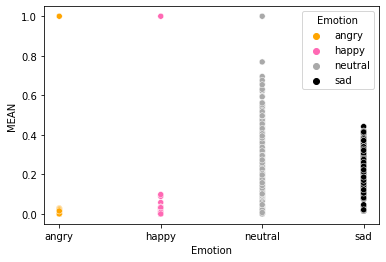

In [ ]:
df = analisa_imagens(200, 150, "blue", 2, "up")
df_normalizado = normaliza(df)
sns.scatterplot(data=df_normalizado, x="Emotion", y="MEAN", hue="Emotion", palette=dict(angry="orange", happy="hotpink", neutral="darkgray", sad="black"));

##### **Experimentos usando a *média* do canal de cor selecionado em função do número de níveis de cor (dentro da região R) com frequência não zero (LNZ)**

###### **Canal Vermelho**

Processando 200 spectrogramas de cada emoção, usando o limiar de 150 , no canal de cor red , com a opção 2  no sentido: up


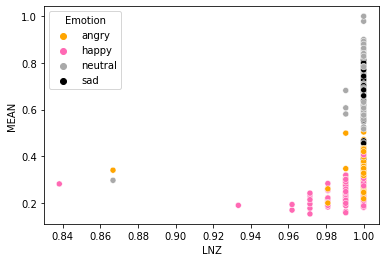

In [ ]:
df = analisa_imagens(200, 150, "red", 2, "up")
df_normalizado = normaliza(df)
sns.scatterplot(data=df_normalizado, x="LNZ", y="MEAN", hue="Emotion", palette=dict(angry="orange", happy="hotpink", neutral="darkgray", sad="black"));

###### **Canal Verde**

Processando 200 spectrogramas de cada emoção, usando o limiar de 150 , no canal de cor green , com a opção 2  no sentido: up


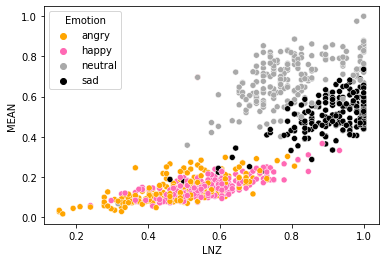

In [ ]:
df = analisa_imagens(200, 150, "green", 2, "up")
df_normalizado = normaliza(df)
sns.scatterplot(data=df_normalizado, x="LNZ", y="MEAN", hue="Emotion", palette=dict(angry="orange", happy="hotpink", neutral="darkgray", sad="black"));

###### **Canal Azul**

Processando 200 spectrogramas de cada emoção, usando o limiar de 150 , no canal de cor blue , com a opção 2  no sentido: up


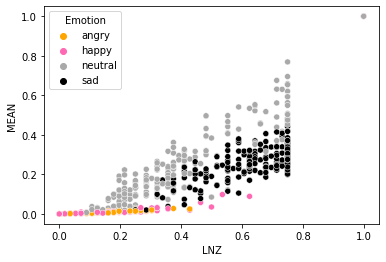

In [ ]:
df = analisa_imagens(200, 150, "blue", 2, "up")
df_normalizado = normaliza(df)
sns.scatterplot(data=df_normalizado, x="LNZ", y="MEAN", hue="Emotion", palette=dict(angry="orange", happy="hotpink", neutral="darkgray", sad="black"));

##### **Salva o Dataframe para um arquivo csv que será importado no Weka**

In [ ]:
df_normalizado.to_csv("voice_emotion_dataframe_norm_red_150_up.csv", sep=',', encoding='utf-8', index=False)

##### **Gerando Matrizes de Confusão**

###### **Canal verde, Threshold = 50**

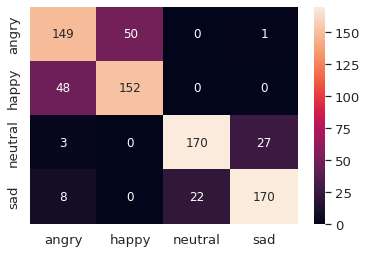

In [ ]:
array = [[149,  50,   0,   1],
         [48, 152,   0,   0],
         [3,   0, 170,  27],
         [8,   0,  22, 170]]
df_cm = pd.DataFrame(array, index=["angry", "happy", "neutral", "sad"], columns=["angry", "happy", "neutral", "sad"])
# df_cm = pd.DataFrame(array, range(4), range(4))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size

plt.show()

###### **Canal verde, Threshold = 150**

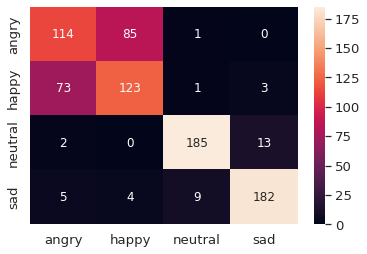

In [ ]:
array = [[114,  85,   1,   0],
         [73, 123,   1,   3],
         [2,   0, 185,  13],
         [5,   4,   9, 182]]
df_cm = pd.DataFrame(array, index=["angry", "happy", "neutral", "sad"], columns=["angry", "happy", "neutral", "sad"])
# df_cm = pd.DataFrame(array, range(4), range(4))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size

plt.show()